In [18]:
target_wav = "Recording_0724"  
infer_wav = target_wav[:-4]

In [21]:
import os
import h5py
import numpy as np
from scipy.ndimage import shift
import soundfile as sf
import torch
import torch.nn as nn
from scipy.signal import medfilt
import datetime
from pyannote.database.util import load_rttm
import speech_recognition as sr

from eend.pytorch_backend.models import TransformerModel, TransformerCNNModel
from eend import feature
from eend import kaldi_data
import sys

import time 

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


def _gen_chunk_indices(data_len, chunk_size):
    step = chunk_size
    start = 0
    while start < data_len:
        end = min(data_len, start + chunk_size)
        yield start, end
        start += step


in_size = feature.get_input_dim(
            200,
            7,
            "logmel23_mn")

## TransformerCNNModel or TransformerModel
model = TransformerModel(
            n_speakers=2,
            in_size=in_size,
            n_units=256,
            n_heads=4,
            n_layers=4,
            has_pos=False
            )

device = torch.device("cuda")
if device.type == "cuda":
    model = nn.DataParallel(model, list(range(1)))
model = model.to(device)

model.load_state_dict(torch.load("./model/transformer334.th"))
model.eval()

DataParallel(
  (module): TransformerModel(
    (encoder): Linear(in_features=345, out_features=256, bias=True)
    (encoder_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_p

In [25]:
from pydub import AudioSegment
ori_path = "./demo_file/" + target_wav + ".wav"   
infer_path = "./demo_file/" + infer_wav + ".wav"
sound = AudioSegment.from_wav(ori_path)
sound = sound.set_frame_rate(8000)  # sample rate 
sound = sound.set_channels(1) # 改成單聲道
sound.export(infer_path, format="wav")

<_io.BufferedRandom name='./demo_file/Recording_.wav'>

In [26]:
##Infer
audio_data, rate = sf.read(infer_path)
Y = feature.stft("True", audio_data, 200, 80)
Y = feature.transform(Y, transform_type="logmel23_mn")
Y = feature.splice(Y, 7)
Y = Y[::10]
out_chunks = []
with torch.no_grad():
    hs = None
    for start, end in _gen_chunk_indices(len(Y), 4000):
        Y_chunked = torch.from_numpy(Y[start:end])
        Y_chunked.to(device)               
        ys = model([Y_chunked], activation=torch.sigmoid)
        out_chunks.append(ys[0].cpu().detach().numpy())
            
outfname = infer_path[:-4] + '.h5'
outdata = np.vstack(out_chunks)
with h5py.File(outfname, 'w') as wf:
    wf.create_dataset('T_hat', data=outdata)
    
##create RTTM file    
threshold = 0.5
median = 11
frame_shift = 80
subsampling = 10
sampling_rate = 8000

out_rttm_file = infer_path[:-4] + ".rttm"
with open(out_rttm_file, 'w') as wf:
    session, _ = os.path.splitext(os.path.basename(outfname))
    data = h5py.File(outfname, 'r')
    a = np.where(data['T_hat'][:] > threshold, 1, 0)
    if median > 1:
        a = medfilt(a, (median, 1))
    for spkid, frames in enumerate(a.T):
        frames = np.pad(frames, (1, 1), 'constant')
        changes, = np.where(np.diff(frames, axis=0) != 0)
        fmt = "SPEAKER {:s} 1 {:7.2f} {:7.2f} <NA> <NA> {:s} <NA>"
        for s, e in zip(changes[
            ::2], changes[1::2]):
            print(fmt.format(
                      session,
                      s * frame_shift * subsampling / sampling_rate,
                      (e - s) * frame_shift * subsampling / sampling_rate,
                      session + "_" + str(spkid)), file=wf)

##read RTTM
with open(out_rttm_file, 'r', encoding='utf-8') as f:
    info = []
    for line in f.readlines():
        l = line.strip()
        l = l.split(" ")
        a = []
        for i in range(len(l)):
            if(l[i] != '' and l[i] != '<NA>'): 
                a.append(l[i])    
        info.append(a) 

In [27]:
# 老師要得逐字稿

from tqdm.notebook import tqdm
r = sr.Recognizer()
WAV = sr.AudioFile(ori_path)
transcript = []
for i in tqdm(range(len(info))):
    offset = float(info[i][3])
    duration = float(info[i][4])
    with WAV as source:
        if(duration<0.3): continue
        r.adjust_for_ambient_noise(source)
        audio = r.record(source, offset=offset-1.0, duration=duration+0.5)
        text = r.recognize_google(audio, language='zh-CN',show_all = True)
        if text != [] : 
            text = text['alternative'][0]['transcript']
#            print('speaker', info[i][5], '(', str(datetime.timedelta(seconds=round(offset))), 's -->',
#                                              str(datetime.timedelta(seconds=round(offset+duration))), 's) : ', text)
            temp = [info[i][5],offset,duration,text]
    transcript.append(temp)


speaker 0 :  0:01  --> 0:03 請問您的編號是多少
speaker 1 :  0:04  --> 0:05 和54088
speaker 0 :  0:05  --> 0:08 好的請問您這兩週去了哪呢
speaker 1 :  0:08  --> 0:12 我去過學校公司全聯茶店還有7-ELEVEN
speaker 0 :  0:12  --> 0:13 好的謝謝


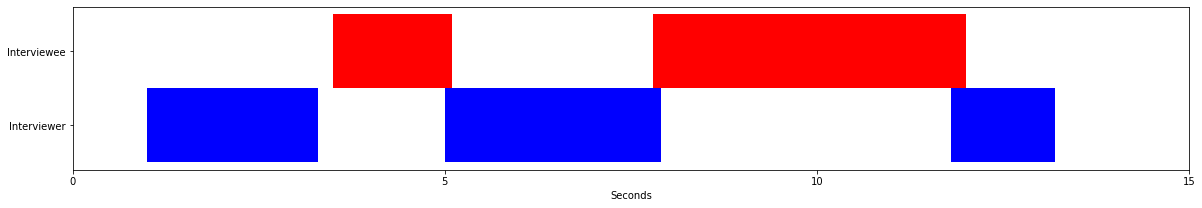

In [28]:
##print transcript
transcript.sort(key = lambda s: s[1])
for i in range(len(transcript)):
    print('speaker', transcript[i][0][-1],': ', str(datetime.timedelta(seconds=round(transcript[i][1])))[-4:], ' -->',
                                          str(datetime.timedelta(seconds=round(transcript[i][2]+transcript[i][1])))[-4:],
                                          transcript[i][3])
    
##plot diarization figure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(20,3))

for i in range(len(info)):
    offset = float(info[i][3])
    duration = float(info[i][4])
    if info[i][5][-1]=='0':
        plt.barh(0, height=1, width=duration, left=offset, color="blue")
    elif info[i][5][-1]=='1':
        plt.barh(1, height=1, width=duration, left=offset, color="red")

n=2
plt.yticks(np.arange(n), ['Interviewer', 'Interviewee'])
plt.xticks(np.arange(0, (len(audio_data)/rate)+5, step=5))
plt.xlabel("Seconds")
plt.show()